## Import libraries

In [24]:
import satlas.util
import torchvision
import json 
import torch 
import skimage.io
import satlas.model.model
import satlas.model.evaluate
import numpy as np
import tqdm
from PIL import Image, ImageDraw, ImageFont
import os
import torchvision
import cv2
from osgeo import gdal
from skimage.measure import find_contours
import satlaspretrain_models
import rasterio
from rasterio.windows import Window

## Load model

In [29]:
from collections import OrderedDict

config_path = 'dataset_x/configs/swinb_mi_ms_rice9.txt'
weights_path = 'dataset_x/output_weights/rice_ms_9/best.pth'

# Read config and initialize the model.
with open(config_path, 'r') as f:
    config = json.load(f)
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")
for spec in config['Tasks']:
    if 'Task' not in spec:
        spec['Task'] = satlas.model.dataset.tasks[spec['Name']]
model = satlas.model.model.Model({
    'config': config['Model'],
    'channels': config['Channels'],
    'tasks': config['Tasks'],
    # 'class_mask' : config['Tasks']['ClassMask']
})

state_dict = torch.load(weights_path, map_location=device)
state_dict['model_state_dict'] = OrderedDict(
    (key.replace('module.', ''), value) for key, value in state_dict['model_state_dict'].items()
)
model.load_state_dict(state_dict['model_state_dict'])
model.to(device)
model.eval()

aggregation backbone: underlying=swin op=max image_channels=9 groups=[[0, 1, 2, 3]]
backbone_channels: [(1, 128), [4, 128], [8, 128], [16, 128], [32, 128]]
Model(
  (backbone): AggregationBackbone(
    (backbone): SwinBackbone(
      (backbone): SwinTransformer(
        (features): Sequential(
          (0): Sequential(
            (0): Conv2d(9, 128, kernel_size=(4, 4), stride=(4, 4))
            (1): Permute()
            (2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
          )
          (1): Sequential(
            (0): SwinTransformerBlockV2(
              (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
              (attn): ShiftedWindowAttentionV2(
                (qkv): Linear(in_features=128, out_features=384, bias=True)
                (proj): Linear(in_features=128, out_features=128, bias=True)
                (cpb_mlp): Sequential(
                  (0): Linear(in_features=2, out_features=512, bias=True)
                  (1): ReLU(inplace=True)


/tmp/ipykernel_3762/1224385874.py:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(weights_path, map_location=device)


Model(
  (backbone): AggregationBackbone(
    (backbone): SwinBackbone(
      (backbone): SwinTransformer(
        (features): Sequential(
          (0): Sequential(
            (0): Conv2d(9, 128, kernel_size=(4, 4), stride=(4, 4))
            (1): Permute()
            (2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
          )
          (1): Sequential(
            (0): SwinTransformerBlockV2(
              (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
              (attn): ShiftedWindowAttentionV2(
                (qkv): Linear(in_features=128, out_features=384, bias=True)
                (proj): Linear(in_features=128, out_features=128, bias=True)
                (cpb_mlp): Sequential(
                  (0): Linear(in_features=2, out_features=512, bias=True)
                  (1): ReLU(inplace=True)
                  (2): Linear(in_features=512, out_features=4, bias=False)
                )
              )
              (stochastic_depth): StochasticDep

/tmp/ipykernel_3175/551501244.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(weights_pathc, map_location=device)


1331
0.4125046104192734
0.427803635597229
0.8151886105939532


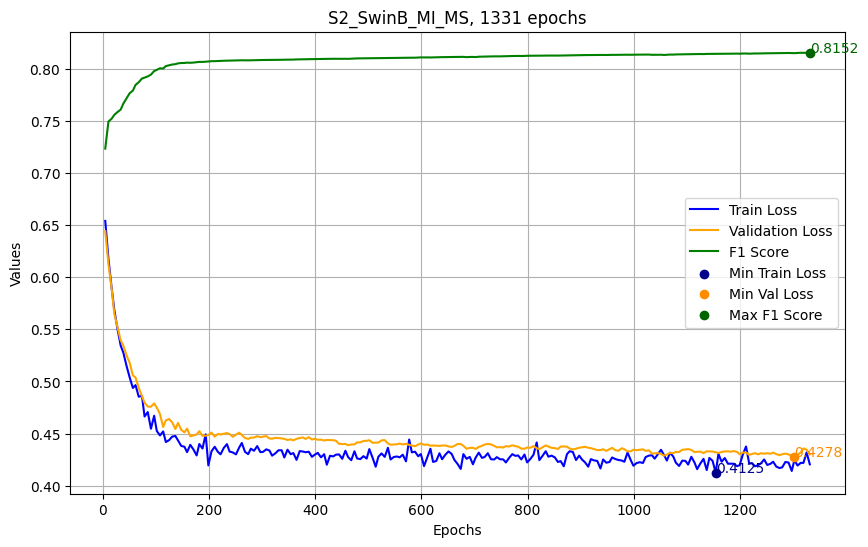

In [4]:
import matplotlib.pyplot as plt
import torch 

device = torch.device("cpu")
weights_pathc = 'dataset_x/output_weights/rice_ms_9/best1342.pth'
state_dict = torch.load(weights_pathc, map_location=device)

train_loss = state_dict['train_loss']
val_loss = state_dict['val_loss']
f1_score = state_dict['val_score']
epochs = state_dict['epoch']

min_train_loss = min(train_loss)
min_val_loss = min(val_loss)
max_f1_score = max(f1_score)

min_train_epoch = epochs[train_loss.index(min_train_loss)]
min_val_epoch = epochs[val_loss.index(min_val_loss)]
max_f1_epoch = epochs[f1_score.index(max_f1_score)]

print(epochs[-1])
print(min_train_loss)
print(min_val_loss)
print(max_f1_score)

if len(train_loss) == len(val_loss) == len(f1_score):
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, train_loss, label='Train Loss', color='blue')
    plt.plot(epochs, val_loss, label='Validation Loss', color='orange')
    plt.plot(epochs, f1_score, label='F1 Score', color='green')
    
    # Đánh dấu các giá trị min/max
    plt.scatter(min_train_epoch, min_train_loss, color='darkblue', label='Min Train Loss', zorder=5)
    plt.text(min_train_epoch, min_train_loss, f'{min_train_loss:.4f}', color='darkblue')

    plt.scatter(min_val_epoch, min_val_loss, color='darkorange', label='Min Val Loss', zorder=5)
    plt.text(min_val_epoch, min_val_loss, f'{min_val_loss:.4f}', color='darkorange')

    plt.scatter(max_f1_epoch, max_f1_score, color='darkgreen', label='Max F1 Score', zorder=5)
    plt.text(max_f1_epoch, max_f1_score, f'{max_f1_score:.4f}', color='darkgreen')

    plt.xlabel('Epochs')
    plt.ylabel('Values')
    plt.title(f'S2_SwinB_MI_MS, {epochs[-1]} epochs')
    plt.legend()
    plt.grid(True)
    
    plt.show()
else:
    print("fail")


/tmp/ipykernel_3175/873100156.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(weights_pathc, map_location=device)


1068
0.4265435867011547
0.4305790185928345
0.816195236013489


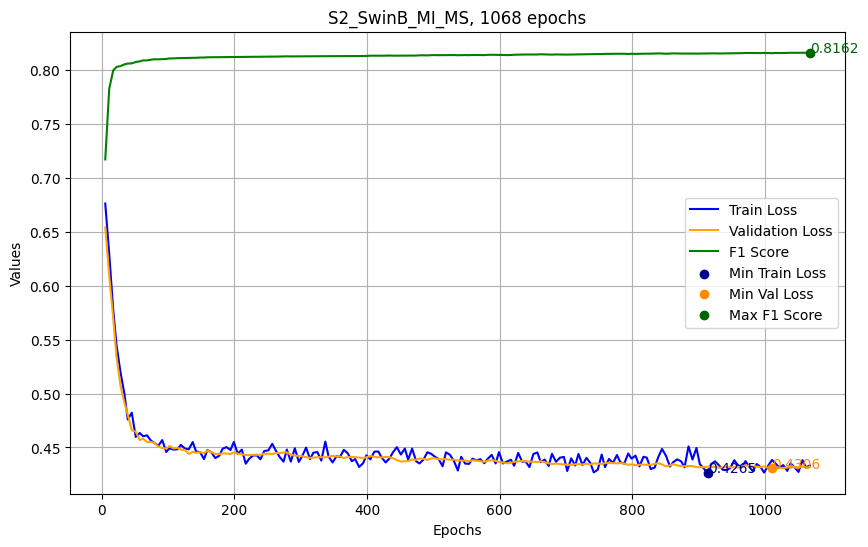

In [2]:
import matplotlib.pyplot as plt
import torch 

device = torch.device("cpu")
weights_pathc = 'dataset_x/output_weights/rice_ms/best.pth'
state_dict = torch.load(weights_pathc, map_location=device)

train_loss = state_dict['train_loss']
val_loss = state_dict['val_loss']
f1_score = state_dict['val_score']
epochs = state_dict['epoch']

min_train_loss = min(train_loss)
min_val_loss = min(val_loss)
max_f1_score = max(f1_score)

min_train_epoch = epochs[train_loss.index(min_train_loss)]
min_val_epoch = epochs[val_loss.index(min_val_loss)]
max_f1_epoch = epochs[f1_score.index(max_f1_score)]

print(epochs[-1])
print(min_train_loss)
print(min_val_loss)
print(max_f1_score)

if len(train_loss) == len(val_loss) == len(f1_score):
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, train_loss, label='Train Loss', color='blue')
    plt.plot(epochs, val_loss, label='Validation Loss', color='orange')
    plt.plot(epochs, f1_score, label='F1 Score', color='green')
    
    # Đánh dấu các giá trị min/max
    plt.scatter(min_train_epoch, min_train_loss, color='darkblue', label='Min Train Loss', zorder=5)
    plt.text(min_train_epoch, min_train_loss, f'{min_train_loss:.4f}', color='darkblue')

    plt.scatter(min_val_epoch, min_val_loss, color='darkorange', label='Min Val Loss', zorder=5)
    plt.text(min_val_epoch, min_val_loss, f'{min_val_loss:.4f}', color='darkorange')

    plt.scatter(max_f1_epoch, max_f1_score, color='darkgreen', label='Max F1 Score', zorder=5)
    plt.text(max_f1_epoch, max_f1_score, f'{max_f1_score:.4f}', color='darkgreen')

    plt.xlabel('Epochs')
    plt.ylabel('Values')
    plt.title(f'S2_SwinB_MI_MS, {epochs[-1]} epochs')
    plt.legend()
    plt.grid(True)
    
    plt.show()
else:
    print("fail")


In [62]:
import glob
import os
import subprocess

channels = ['B08', 'TCI', 'B05', 'B06', 'B07', 'B11', 'B12']
fnames = []
for scene_name in os.listdir('dataset_x'): # folder luu data
    image_fnames = glob.glob(os.path.join('dataset_x/sentinel2_data/VN60111/VN60111_*_2024_05_01_2024_11_01_S2/*_Image*.tif'.format(scene_name)))
    channel_to_fname = {fname.split('_')[-9].split('.')[0]: fname for fname in image_fnames}
    selected_fnames = [channel_to_fname[channel] for channel in channels]
    fnames.extend(selected_fnames)
    # print(scene_name)
print(f"selected: {len(fnames)}")
# subprocess.call([
#     'gdal_merge.py',
#     '-o', 'dataset_x/results/stack_thaibinh_ms.tif',
#     # Keep bands separate in output file.
#     '-separate',
# ] + fnames)


# import glob
# import os

# # Đường dẫn tới tất cả các file .tif
# image_fnames = glob.glob(os.path.join('dataset_x/sentinel2_data/VN60111/VN60111_*/VN60111_*/*.tif'))

# # Danh sách các channel cần lấy
# channels = ['B08', 'TCI', 'B05', 'B06', 'B07', 'B11', 'B12'] # Thay đổi tùy theo nhu cầu của bạn

# fnames = []  # Nơi lưu các file đã chọn

# # Lấy danh sách tất cả các folder
# folders = set(os.path.dirname(fname) for fname in image_fnames)

# # Duyệt qua từng folder
# for folder in folders:
#     # Lấy tất cả file .tif trong folder hiện tại
#     folder_files = glob.glob(os.path.join(folder, '*.tif'))
    
#     # Ánh xạ channel với file trong folder hiện tại
#     channel_to_fname = {fname.split('_')[-9].split('.')[0]: fname for fname in folder_files}
    
#     # Chọn file theo channel chỉ định
#     selected_fnames = []
#     for channel in channels:
#         if channel in channel_to_fname:
#             selected_fnames.append(channel_to_fname[channel])
#         else:
#             print(f"Channel {channel} không tồn tại trong folder: {folder}")
    
#     # Thêm các file đã chọn từ folder vào danh sách tổng
#     fnames.extend(selected_fnames)

# # Kết quả
# print(f"Tổng số folder: {len(folders)}")
# print(f"Tổng số file được chọn: {len(fnames)}")




selected: 63


In [80]:

# image = image.reshape(image.shape[0]*image.shape[1], image.shape[2], image.shape[3])
image.shape

(4, 256, 256)

## run inference

#### visualize

In [ ]:
import os
import numpy as np
from osgeo import gdal

# Đường dẫn tới folder chứa các ảnh
folder_path = "cr/CR_test_processed/XXX"
output_tif = "cr/CR_test_processed/stacked_cr.tif"

# Lấy danh sách các file .tif trong folder
tif_files = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith('.tif')]

# Kiểm tra số lượng file
if len(tif_files) != 8:
    raise ValueError("Folder cần chứa đúng 8 file TIFF.")

# Danh sách để chứa các mảng ảnh
images = []

# Đọc từng file và thêm vào danh sách
for tif_file in tif_files:
    raster = gdal.Open(tif_file)
    image = raster.ReadAsArray()  # Shape: (4, 256, 256)
    if image.shape != (4, 256, 256):
        raise ValueError(f"File {tif_file} không có shape (4, 256, 256).")

    # Xác định kích thước ảnh
    bands, height, width = image.shape  # bands=4, height=256, width=256

    # Tạo mảng với shape (9, 256, 256)
    new_image = np.zeros((9, height, width), dtype=image.dtype)

    # Gán dữ liệu từ ảnh ban đầu vào các kênh tương ứng
    new_image[:bands, :, :] = image  # Copy 4 bands RGBN

    
    images.append(new_image)  # Thêm ảnh vào danh sách

# Stack các mảng thành một mảng duy nhất với shape (8, 4, 256, 256)
stacked_image = np.stack(images, axis=0)

# Kiểm tra shape đầu ra
print("Shape của ảnh đã stack:", stacked_image.shape)  # (8, 4, 256, 256)

# Lưu mảng stack thành 1 ảnh GeoTIFF mới
driver = gdal.GetDriverByName('GTiff')
output_raster = driver.Create(output_tif, 256, 256, 72, gdal.GDT_Byte)  # 8 x 4 = 32 bands

# Ghi từng kênh vào file GeoTIFF
for i in range(stacked_image.shape[0]):
    for j in range(stacked_image.shape[1]):
        band_index = i * 9 + j + 1
        output_raster.GetRasterBand(band_index).WriteArray(stacked_image[i, j, :, :])

# Đóng file
output_raster.FlushCache()
output_raster = None

print(f"Ảnh GeoTIFF đã được lưu tại {output_tif}.")

Shape của ảnh đã stack: (8, 9, 256, 256)
Ảnh GeoTIFF đã được lưu tại cr/CR_test_processed/stacked_cr.tif.


In [128]:
img_path = 'cr/CR_test_processed/stacked_cr.tif'
raster = gdal.Open(img_path)
img_path_name = 'tci'#os.path.splitext(os.path.basename(img_path))[0].split('_')[1]
image = raster.ReadAsArray()

# Separate out the different 9-band images.
image = image.reshape(-1, 9, image.shape[1], image.shape[2])
# Re-order bands to the order expected by the model.
image = image[:, (0, 1, 2, 4, 5, 6, 3, 7, 8), :, :]
# Normalize the non-TCI bands to be 0-255.
image[:, 3:9, :, :] = np.clip(image[:, 3:9, :, :]//1, 0, 255)
image = image.astype(np.uint8)
# print(image[:, :1, :,:].shape)

In [129]:
################ RGB ################

# class_id = {'invalid': 0, 'rice': 1, 'grape': 2, 'corn': 3, 'sugarcane': 4, 'tea': 5, 'hop': 6, 'wheat': 7, 'soy': 8, 'barley': 9, 'oats': 10, 'rye': 11, 'cassava': 12, 'potato': 13, 'sunflower': 14, 'asparagus': 15, 'coffee': 16}
# image = stack_array
# img_path = '/mnt/data2tb/TungCT/ekGIS/tungct/tung_work/satlas/potato_bacninh_ms/corn_00268.tif'
# img_path = 'stack_thaibinh_ms/vn115_7_9.tif'
# with rasterio.open(img_path) as src:
#                         print(f"Number of bands: {src.count}")
#                         for i in range(1, src.count + 1):
#                             band = src.read(i)
#                             band_min = band.min()  # Giá trị nhỏ nhất trong band
#                             band_max = band.max()  # Giá trị lớn nhất trong band
#                             print(f"Band {i}: Min = {band_min}, Max = {band_max}")
# raster = gdal.Open(img_path)
# img_path_name = 'tci'#os.path.splitext(os.path.basename(img_path))[0].split('_')[1]
# image = raster.ReadAsArray()

# # Separate out the different 9-band images.
# image = image.reshape(-1, 9, image.shape[1], image.shape[2])
# # Re-order bands to the order expected by the model.
# image = image[:, (1, 2, 3, 4, 5, 6, 0, 7, 8), :, :]
# # Normalize the non-TCI bands to be 0-255.
# # image[:, 3:9, :, :] = np.clip(image[:, 3:9, :, :]//32, 0, 255)

# image = image.astype(np.uint8)
# # print(image[:, 3:9, :, :])
# Save the 8-bit image.
# image = image.astype(np.uint8)

print(image.shape)
# For (N, C, H, W) image (with N timestamps), convert to (N*C, H, W).
image = image.reshape(image.shape[0]*image.shape[1], image.shape[2], image.shape[3])

# The image is large so apply it on windows.
# Here we collect outputs from head 0 which is the only head of the solar farm model.
vis_output = np.zeros((image.shape[1], image.shape[2], 3), dtype=np.uint8)
crop_size = 1024
head_idx = 0
task_name = config['Tasks'][head_idx]['Name']

with torch.no_grad():
    for row in tqdm.tqdm(range(0, image.shape[1], crop_size)):
        for col in range(0, image.shape[2], crop_size):
            crop = image[:, row:row+crop_size, col:col+crop_size]
            vis_crop = crop.transpose(1, 2, 0)[:, :, 0:3]
            gpu_crop = torch.as_tensor(crop).to(device).float() / 255
            outputs, _ = model([gpu_crop])
            vis_output_crop, _, _, _ = satlas.model.evaluate.visualize_outputs(
            # vis_output_crop, _, _, _ = visualize_outputs(
                task=config['Tasks'][head_idx]['Task'],
                image=vis_crop,
                outputs=outputs[head_idx][0],
                return_vis=True,
                # evaluator_params=[0.9]*2
            )
            # if len(vis_output_crop.shape) == 2:
            #     vis_output[row:row+crop_size, col:col+crop_size, 0] = vis_output_crop
            #     vis_output[row:row+crop_size, col:col+crop_size, 1] = vis_output_crop
            #     vis_output[row:row+crop_size, col:col+crop_size, 2] = vis_output_crop
            # else:
            #     vis_output[row:row+crop_size, col:col+crop_size, :] = vis_output_crop
os.makedirs('2712_multiimage_ms', exist_ok=True)
# skimage.io.imsave(f'2712_multiimage_ms/{img_path_name}_rgb.png', image[0:3, :, :].transpose(1, 2, 0))
skimage.io.imsave(f'2712_multiimage_ms/{img_path_name}_{task_name}_output00ff.png', vis_output_crop)

(8, 9, 256, 256)


100%|██████████| 1/1 [00:01<00:00,  1.83s/it]
/tmp/ipykernel_3762/3749864151.py:64: UserWarning: 2712_multiimage_ms/tci_crop_type_output00ff.png is a low contrast image
  skimage.io.imsave(f'2712_multiimage_ms/{img_path_name}_{task_name}_output00ff.png', vis_output_crop)


In [8]:
import os
import rasterio

def read_png_band_min_max(folder_path):
    for root, dirs, files in os.walk(folder_path):  # Duyệt qua các thư mục và file
        for file in files:
            if file.endswith('.png'):  # Chỉ lấy file có đuôi .png
                file_path = os.path.join(root, file)
                print(f"\nImage: {file_path}")
                
                # Đọc giá trị các bands trong ảnh
                try:
                    with rasterio.open(file_path) as src:
                        print(f"Number of bands: {src.count}")
                        for i in range(1, src.count + 1):
                            band = src.read(i)
                            band_min = band.min()  # Giá trị nhỏ nhất trong band
                            band_max = band.max()  # Giá trị lớn nhất trong band
                            print(f"Band {i}: Min = {band_min}, Max = {band_max}")
                except Exception as e:
                    print(f"Error reading {file_path}: {e}")

# Thay đổi 'your_folder_path' thành đường dẫn folder của bạn
your_folder_path = "dataset_x/datasets/crop_type"
read_png_band_min_max(your_folder_path)



Image: dataset_x/datasets/crop_type/VN115_8_8/gt.png


/mnt/data2tb/TungCT/ekGIS/tungct/tung_work/lib/python3.10/site-packages/rasterio/__init__.py:355: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Number of bands: 1
Band 1: Min = 0, Max = 1

Image: dataset_x/datasets/crop_type/VN115_8_8/images/Image8/tci.png
Number of bands: 3
Band 1: Min = 0, Max = 255
Band 2: Min = 0, Max = 255
Band 3: Min = 0, Max = 255

Image: dataset_x/datasets/crop_type/VN115_8_8/images/Image8/b07.png
Number of bands: 1
Band 1: Min = 0, Max = 255

Image: dataset_x/datasets/crop_type/VN115_8_8/images/Image8/b05.png
Number of bands: 1
Band 1: Min = 0, Max = 255

Image: dataset_x/datasets/crop_type/VN115_8_8/images/Image8/b12.png
Number of bands: 1
Band 1: Min = 17, Max = 255

Image: dataset_x/datasets/crop_type/VN115_8_8/images/Image8/b08.png
Number of bands: 1
Band 1: Min = 0, Max = 255

Image: dataset_x/datasets/crop_type/VN115_8_8/images/Image8/b11.png
Number of bands: 1
Band 1: Min = 17, Max = 255

Image: dataset_x/datasets/crop_type/VN115_8_8/images/Image8/b06.png
Number of bands: 1
Band 1: Min = 0, Max = 255

Image: dataset_x/datasets/crop_type/VN115_8_8/images/Image3/tci.png
Number of bands: 3
Band 1:

In [5]:
# gop 8 anh tif
import glob
import os
import subprocess

# channels = ['B08', 'TCI', 'B05', 'B06', 'B07', 'B11', 'B12']
channels = ['TCI']
path = 'dataset_x/sentinel2_data/VN115_05_2024_11_2024_S2-20241218T042705Z-001/VN115_05_2024_11_2024_S2'
fnames = glob.glob(f'{path}/*.tif')
subprocess.call([
    'gdal_merge.py',
    '-o', 'dataset_x/results/stack_rgb.tif',
    # Keep bands separate in output file.
    '-separate',
] + fnames)

0...10...20...30...40...50...60...70...80...90...100 - done.


0

In [14]:
# cat anh tif stack luu lai vao kq
import rasterio
from rasterio.windows import Window
import os

input_folder = "/mnt/data2tb/TungCT/ekGIS/tungct/tung_work/satlas/stack_images/dddddddd"
output_folder = "/mnt/data2tb/TungCT/ekGIS/tungct/tung_work/satlas/stack_images/dddddddd"

os.makedirs(output_folder, exist_ok=True)

test_folder = ["VN115_7_9", "VN115_2_5", "VN115_6_8", "VN115_6_2", "VN115_0_3"]

def process_tif_folder(input_folder, output_folder, tile_size=512):
    for file_name in os.listdir(input_folder):
        if file_name.endswith(".tif"):

            input_file_path = os.path.join(input_folder, file_name)
            
            day = file_name.split("_")[-1].replace(".tif", "")
            
            with rasterio.open(input_file_path) as src:
                width, height = src.width, src.height

                for i in range(0, height, tile_size):
                    for j in range(0, width, tile_size):
                        window = Window(j, i, tile_size, tile_size)
                        transform = src.window_transform(window)

                        tile = src.read(window=window)
                        
                        tile_height, tile_width = tile.shape[1], tile.shape[2]
                        if tile_height < tile_size or tile_width < tile_size:
                            # Nếu tile nhỏ hơn 512x512, bỏ qua
                            continue

                        tile_folder = os.path.join(output_folder, f"VN115_{i // tile_size}_{j // tile_size}", "images", day)
                        os.makedirs(tile_folder, exist_ok=True)

                        # Lưu tile với tên "tci.png"
                        output_tile_path = os.path.join(tile_folder, "tci.tif")
                        with rasterio.open(
                            output_tile_path,
                            "w",
                            driver="GTiff",
                            height=tile.shape[1],
                            width=tile.shape[2],
                            count=tile.shape[0],
                            dtype=tile.dtype,
                            crs=src.crs,
                            transform=transform,
                        ) as dst:
                            dst.write(tile)
                            
                        if tile_height < tile_size or tile_width < tile_size:
                            os.remove(tile_folder)
                        
                        
                        # print(count)
    # Xóa các folder không nằm trong test_folder
    # clean_up_folders(output_folder, test_folder)


def clean_up_folders(output_folder, test_folder):
    # Lấy danh sách các folder con trong output_folder
    subfolders = [f for f in os.listdir(output_folder) if os.path.isdir(os.path.join(output_folder, f))]
    
    for folder in subfolders:
        if folder not in test_folder:
            # Nếu folder không nằm trong test_folder, xóa toàn bộ
            folder_path = os.path.join(output_folder, folder)
            shutil.rmtree(folder_path)
            print(f"Đã xóa folder: {folder_path}")
        else:
            print(f"Giữ lại folder: {folder}")

# Thực hiện xử lý
process_tif_folder(input_folder, output_folder)


KeyboardInterrupt: 

In [72]:

# Separate out the different 9-band images.
# image = image.reshape(-1, 9, image.shape[1], image.shape[2])
# print(image.shape)
# # Re-order bands to the order expected by the model.
# image = image[:, (1, 2, 3, 4, 5, 6, 0, 7, 8), :, :]
# # Normalize the non-TCI bands to be 0-255.
# image[:, 3:9, :, :] = np.clip(image[:, 3:9, :, :]//32, 0, 255)


#### TACH CLASSES

In [7]:
############### TACH CLASSES ###############
################### RGB ####################
################ Land cover, Crop type ################
head_idx = 4
task_name = config['Tasks'][head_idx]['Name']
if head_idx == 2:
    class_id = {'background': 0, 'water': 1, 'developed': 2, 'tree': 3, 'shrub': 4, 'grass': 5, 'crop': 6, 'bare': 7, 'snow': 8, 'wetland': 9, 'mangroves': 10, 'moss': 11}
if head_idx == 4:
    class_id = {'invalid': 0, 'rice': 1, 'grape': 2, 'corn': 3, 'sugarcane': 4, 'tea': 5, 'hop': 6, 'wheat': 7, 'soy': 8, 'barley': 9, 'oats': 10, 'rye': 11, 'cassava': 12, 'potato': 13, 'sunflower': 14, 'asparagus': 15, 'coffee': 16}

dir_0512 = f'2112_multiimage_rgb/anh1'
img_path = 'dataset_x/results/thaibinh/crop_stack_rgb/VN115_7_9/images/rgb/tci.tif'
img_path_name = 'tci' #os.path.splitext(os.path.basename(img_path))[0].split('_')[1]

# input_folder = 'cassava_10'

raster = gdal.Open(img_path)
image = raster.ReadAsArray()
# Save the 8-bit image.
image = image.astype(np.uint8)
print(image.shape)

vis_output = np.zeros((image.shape[1], image.shape[2], 3), dtype=np.uint8)
crop_size = 1024


for index in class_id:
    class_idx = class_id[index]

    def segmentation_mask_to_color_full(task, label_im, gt=None):
        if task['type'] == 'segment':
            vis = np.zeros((label_im.shape[0], label_im.shape[1], 3), dtype='uint8')
            for cls, color in enumerate(task['colors']):
                vis[label_im == cls] = color
                # print(task['colors'][2])

            if task.get('BackgroundInvalid', False) and gt:
                # Mask out pixels in label_im that are background in the ground truth labels.
                vis[gt == 0] = task['colors'][0]

        return vis

    def segmentation_mask_to_color(task, label_im, image, gt=None):
        if task['type'] == 'segment':
            vis = np.zeros((label_im.shape[0], label_im.shape[1], 3), dtype='uint8')
            # print('label_im shape ', np.shape(label_im))
            for cls in np.unique(label_im): # (512, 512)
                if class_idx == cls:
                    # print(cls)
                    mask = np.zeros_like(label_im, dtype=np.uint8)
                    mask[label_im == cls] = 255
                    # print('Mask shape: ', mask.shape)
                    contours, _ = cv2.findContours(mask, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)
                    image = np.ascontiguousarray(image, dtype=np.uint8)
                    cv2.drawContours(image, contours, -1, task['colors'][cls], cv2.FILLED)
        return image

    def visualize_outputs(task, image, outputs, targets=None, return_vis=False, return_out=False, evaluator_params=None):
        task_type = task['type']
        vis_output = None
        vis_gt = None
        raw_outputs = None
        raw_output_format = None

        if task_type == 'segment':
            if evaluator_params:
                pred_probs = outputs.cpu().numpy()
                pred_cls = np.zeros(pred_probs.shape[1:3], dtype=np.uint8)
                for cls_id, threshold in enumerate(evaluator_params):
                    pred_cls[pred_probs[cls_id, :, :] > threshold] = cls_id
            else:
                pred_cls = outputs.argmax(dim=0).cpu().numpy()

            if return_vis:
                if class_idx==0:
                    vis_output = segmentation_mask_to_color_full(task, pred_cls)
                else:
                    # pass
                    vis_output = segmentation_mask_to_color(task, pred_cls, image)

                if targets:
                    vis_gt = segmentation_mask_to_color(task, targets['im'].numpy())

            if return_out:
                raw_outputs = pred_cls.astype(np.uint8)
                raw_output_format = 'png'
        return vis_output, vis_gt, raw_outputs, raw_output_format



    with torch.no_grad():
        for row in tqdm.tqdm(range(0, image.shape[1], crop_size)):
            for col in range(0, image.shape[2], crop_size):
                crop = image[:, row:row+crop_size, col:col+crop_size]
                vis_crop = crop.transpose(1, 2, 0)[:, :, 0:3]
                gpu_crop = torch.as_tensor(crop).to(device).float() / 255
                outputs, _ = model([gpu_crop])
                
                # class_idx = class_id['developed']
                out = outputs[head_idx][0]
                chosen_out = torch.zeros_like(out, device='cuda:0')
                chosen_out[class_idx] = out[class_idx]                

                # vis_output_crop, _, _, _ = satlas.model.evaluate.visualize_outputs(
                vis_output_crop, _, _, _ = visualize_outputs(
                    task=config['Tasks'][head_idx]['Task'],
                    image=vis_crop,
                    outputs=out,
                    return_vis=True,
                )
                # if len(vis_output_crop.shape) == 2:
                #     vis_output[row:row+crop_size, col:col+crop_size, 0] = vis_output_crop
                #     vis_output[row:row+crop_size, col:col+crop_size, 1] = vis_output_crop
                #     vis_output[row:row+crop_size, col:col+crop_size, 2] = vis_output_crop
                # else:
                #     vis_output[row:row+crop_size, col:col+crop_size, :] = vis_output_crop

    os.makedirs(dir_0512, exist_ok=True)
    skimage.io.imsave(f'2112_multiimage_rgb/anh1/{img_path_name}_{class_idx}_{index}_rgb.png', image[0:3, :, :].transpose(1, 2, 0))
    skimage.io.imsave(f'2112_multiimage_rgb/anh1/{img_path_name}_{class_idx}_{index}.png', vis_output_crop)

(24, 512, 512)


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.09it/s]


In [56]:
#mask
img = cv2.imread('_rgb_rgb.png')
mask = cv2.imread('gfhhghg_output_rgb_crop.png',0)
res = cv2.bitwise_and(img,img,mask = mask)
res = res.astype(np.uint8)
print(res.shape)
# a = cv2.imwrite('masked_and.png',res)

# res = cv2.bitwise_or(img,img,mask = mask)
# b = cv2.imwrite('masked_or.png',res)

# res = cv2.bitwise_xor(img,img,mask = mask)
# c = cv2.imwrite('masked_xor.png',res)

(512, 512, 3)


In [9]:
############### TACH CLASSES ###############
################### RGB ####################
################ Land cover, Crop type ################
head_idx = 4
task_name = config['Tasks'][head_idx]['Name']
if head_idx == 2:
    class_id = {'background': 0, 'water': 1, 'developed': 2, 'tree': 3, 'shrub': 4, 'grass': 5, 'crop': 6, 'bare': 7, 'snow': 8, 'wetland': 9, 'mangroves': 10, 'moss': 11}
if head_idx == 4:
    class_id = {'invalid': 0, 'rice': 1, 'grape': 2, 'corn': 3, 'sugarcane': 4, 'tea': 5, 'hop': 6, 'wheat': 7, 'soy': 8, 'barley': 9, 'oats': 10, 'rye': 11, 'cassava': 12, 'potato': 13, 'sunflower': 14, 'asparagus': 15, 'coffee': 16}

dir_0512 = '1012_multiimage_rgb/anh4'
img_path = 'thaibinh_rice/corn_00054.tif'
img_path_name = os.path.splitext(os.path.basename(img_path))[0].split('_')[1]

# input_folder = 'cassava_10'

raster = gdal.Open(img_path)
image = raster.ReadAsArray()
# Save the 8-bit image.
image = image.astype(np.uint8)
print(image.shape)

vis_output = np.zeros((image.shape[1], image.shape[2], 3), dtype=np.uint8)
crop_size = 1024


index = 'rice'
class_idx = class_id[index]

def segmentation_mask_to_color_full(task, label_im, gt=None):
        if task['type'] == 'segment':
            vis = np.zeros((label_im.shape[0], label_im.shape[1], 3), dtype='uint8')
            for cls, color in enumerate(task['colors']):
                vis[label_im == 1] = color
                # print(task['colors'][2])

            if task.get('BackgroundInvalid', False) and gt:
                # Mask out pixels in label_im that are background in the ground truth labels.
                vis[gt == 0] = task['colors'][0]

        return vis

def segmentation_mask_to_color(task, label_im, image, gt=None):
        if task['type'] == 'segment':
            vis = np.zeros((label_im.shape[0], label_im.shape[1], 3), dtype='uint8')
            # print('label_im shape ', np.shape(label_im))
            for cls in np.unique(label_im): # (512, 512)
                if class_idx == cls:
                    # print(cls)
                    mask = np.zeros_like(label_im, dtype=np.uint8)
                    mask[label_im == cls] = 255
                    # print('Mask shape: ', mask.shape)
                    contours, _ = cv2.findContours(mask, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)
                    image = np.ascontiguousarray(image, dtype=np.uint8)
                    cv2.drawContours(image, contours, -1, task['colors'][cls], cv2.FILLED)
        return image

def visualize_outputs(task, image, outputs, targets=None, return_vis=False, return_out=False, evaluator_params=None):
        task_type = task['type']
        vis_output = None
        vis_gt = None
        raw_outputs = None
        raw_output_format = None

        if task_type == 'segment':
            if evaluator_params:
                pred_probs = outputs.cpu().numpy()
                pred_cls = np.zeros(pred_probs.shape[1:3], dtype=np.uint8)
                for cls_id, threshold in enumerate(evaluator_params):
                    pred_cls[pred_probs[cls_id, :, :] > threshold] = cls_id
            else:
                pred_cls = outputs.argmax(dim=0).cpu().numpy()

            if return_vis:
                if class_idx==1:
                    vis_output = segmentation_mask_to_color_full(task, pred_cls)
                else:
                    pass
                    # vis_output = segmentation_mask_to_color(task, pred_cls, image)

                if targets:
                    vis_gt = segmentation_mask_to_color(task, targets['im'].numpy())

            if return_out:
                raw_outputs = pred_cls.astype(np.uint8)
                raw_output_format = 'png'
        return vis_output, vis_gt, raw_outputs, raw_output_format



with torch.no_grad():
        for row in tqdm.tqdm(range(0, image.shape[1], crop_size)):
            for col in range(0, image.shape[2], crop_size):
                crop = image[:, row:row+crop_size, col:col+crop_size]
                vis_crop = crop.transpose(1, 2, 0)[:, :, 0:3]
                gpu_crop = torch.as_tensor(crop).to(device).float() / 255
                outputs, _ = model([gpu_crop])
                
                # class_idx = class_id['developed']
                out = outputs[head_idx][0]
                chosen_out = torch.zeros_like(out, device='cuda:0')
                chosen_out[class_idx] = out[class_idx]                

                # vis_output_crop, _, _, _ = satlas.model.evaluate.visualize_outputs(
                vis_output_crop, _, _, _ = visualize_outputs(
                    task=config['Tasks'][head_idx]['Task'],
                    image=vis_crop,
                    outputs=out,
                    return_vis=True,
                )
                # if len(vis_output_crop.shape) == 2:
                #     vis_output[row:row+crop_size, col:col+crop_size, 0] = vis_output_crop
                #     vis_output[row:row+crop_size, col:col+crop_size, 1] = vis_output_crop
                #     vis_output[row:row+crop_size, col:col+crop_size, 2] = vis_output_crop
                # else:
                #     vis_output[row:row+crop_size, col:col+crop_size, :] = vis_output_crop

os.makedirs(dir_0512, exist_ok=True)
skimage.io.imsave(f'{dir_0512}/{img_path_name}_{class_idx}_{index}_rgb.png', image[0:3, :, :].transpose(1, 2, 0))
skimage.io.imsave(f'{dir_0512}/{img_path_name}_{class_idx}_{index}.png', vis_output_crop)

(24, 512, 512)


  0%|          | 0/1 [00:04<?, ?it/s]


ValueError: targets should not be None

In [8]:
config['Tasks'][0]['Task']

{'mode': 'custom',
 'type': 'segment',
 'categories': ['background', 'rice'],
 'colors': [[0, 0, 0], [255, 0, 0]]}

In [12]:
print(model)

Model(
  (backbone): AggregationBackbone(
    (backbone): SwinBackbone(
      (backbone): SwinTransformer(
        (features): Sequential(
          (0): Sequential(
            (0): Conv2d(3, 128, kernel_size=(4, 4), stride=(4, 4))
            (1): Permute()
            (2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
          )
          (1): Sequential(
            (0): SwinTransformerBlockV2(
              (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
              (attn): ShiftedWindowAttentionV2(
                (qkv): Linear(in_features=128, out_features=384, bias=True)
                (proj): Linear(in_features=128, out_features=128, bias=True)
                (cpb_mlp): Sequential(
                  (0): Linear(in_features=2, out_features=512, bias=True)
                  (1): ReLU(inplace=True)
                  (2): Linear(in_features=512, out_features=4, bias=False)
                )
              )
              (stochastic_depth): StochasticDep

In [12]:
# image = torchvision.io.read_image('masked_and.png')
# image = np.expand_dims(image, axis = 0)
raster = gdal.Open('thaibinh_rice/corn_00054.tif')
image = raster.ReadAsArray()

# Separate out the different 9-band images.
# image = image.reshape(-1, 12, image.shape[1], image.shape[2])
# print(image.shape)
# # Re-order bands to the order expected by the model.
# image = image[:, (1, 2, 3, 4, 5, 6, 0, 7, 8), :, :]
# # Normalize the non-TCI bands to be 0-255.
# image[:, 3:9, :, :] = np.clip(image[:, 3:9, :, :]//32, 0, 255)
# Save the 8-bit image.
image = image.astype(np.uint8)

# print(image.shape)
# For (N, C, H, W) image (with N timestamps), convert to (N*C, H, W).
# image = image.reshape(image.shape[0]*image.shape[1], image.shape[2], image.shape[3])

# The image is large so apply it on windows.
# Here we collect outputs from head 0 which is the only head of the solar farm model.
vis_output = np.zeros((image.shape[1], image.shape[2], 3), dtype=np.uint8)
crop_size = 1024
head_idx = 0

with torch.no_grad():
    for row in tqdm.tqdm(range(0, image.shape[1], crop_size)):
        for col in range(0, image.shape[2], crop_size):
            crop = image[:, row:row+crop_size, col:col+crop_size]
            vis_crop = crop.transpose(1, 2, 0)[:, :, 0:3]
            gpu_crop = torch.as_tensor(crop).to(device).float() / 255
            outputs, _ = model([gpu_crop])
            print(outputs)
            vis_output_crop, _, _, _ = satlas.model.evaluate.visualize_outputs(
            # vis_output_crop, _, _, _ = visualize_outputs(
                task=config['Tasks'][head_idx]['Task'],
                image=vis_crop,
                outputs=outputs[head_idx][0],
                return_vis=True,
            )
            # if len(vis_output_crop.shape) == 2:
            #     vis_output[row:row+crop_size, col:col+crop_size, 0] = vis_output_crop
            #     vis_output[row:row+crop_size, col:col+crop_size, 1] = vis_output_crop
            #     vis_output[row:row+crop_size, col:col+crop_size, 2] = vis_output_crop
            # else:
            #     vis_output[row:row+crop_size, col:col+crop_size, :] = vis_output_crop

skimage.io.imsave('test_rice_rgb.png', image[0:3, :, :].transpose(1, 2, 0))
skimage.io.imsave('test_mask.png', vis_output_crop)

100%|██████████| 1/1 [00:06<00:00,  6.34s/it]

[tensor([[[[0.4811, 0.5026, 0.4865,  ..., 0.5046, 0.4987, 0.5075],
          [0.4912, 0.4849, 0.4994,  ..., 0.4930, 0.5057, 0.5034],
          [0.4859, 0.5053, 0.4610,  ..., 0.5019, 0.4778, 0.4989],
          ...,
          [0.4828, 0.4651, 0.5068,  ..., 0.5113, 0.4961, 0.5163],
          [0.4739, 0.4994, 0.4828,  ..., 0.5047, 0.4871, 0.4988],
          [0.4963, 0.4907, 0.4909,  ..., 0.5116, 0.5122, 0.5097]],

         [[0.5189, 0.4974, 0.5135,  ..., 0.4954, 0.5013, 0.4925],
          [0.5088, 0.5151, 0.5006,  ..., 0.5070, 0.4943, 0.4966],
          [0.5141, 0.4947, 0.5390,  ..., 0.4981, 0.5222, 0.5011],
          ...,
          [0.5172, 0.5349, 0.4932,  ..., 0.4887, 0.5039, 0.4837],
          [0.5261, 0.5006, 0.5172,  ..., 0.4953, 0.5129, 0.5012],
          [0.5037, 0.5093, 0.5091,  ..., 0.4884, 0.4878, 0.4903]]]])]



/tmp/ipykernel_3622/2903915005.py:49: UserWarning: test_mask.png is a low contrast image
  skimage.io.imsave('test_mask.png', vis_output_crop)


In [ ]:
import json
import random

def generate_random_data(num_entries=2, max_value=512, max_value2= 100):
    return [
        [
            random.randint(0, max_value2 - 50),  # x_min
            random.randint(0, max_value - 50),  # y_min
            random.randint(50, max_value2),     # x_max
            random.randint(50, max_value),     # y_max
            "wind_turbine"                     # label
        ]
        for _ in range(num_entries)
    ]

file_count = 10
for i in range(file_count):
    data = generate_random_data()
    file_name = f"gt_{i+1}.json"
    with open(file_name, 'w') as f:
        json.dump(data, f, indent=4)
        
        print(data)


[[24, 134, 70, 340, 'wind_turbine'], [36, 219, 65, 103, 'wind_turbine']]
[[16, 75, 65, 50, 'wind_turbine'], [30, 265, 72, 152, 'wind_turbine']]
[[38, 462, 82, 223, 'wind_turbine'], [30, 417, 75, 213, 'wind_turbine']]
[[23, 462, 67, 66, 'wind_turbine'], [19, 235, 65, 239, 'wind_turbine']]
[[43, 258, 52, 94, 'wind_turbine'], [24, 36, 75, 230, 'wind_turbine']]
[[22, 103, 100, 316, 'wind_turbine'], [32, 450, 60, 496, 'wind_turbine']]
[[39, 185, 68, 153, 'wind_turbine'], [27, 264, 74, 150, 'wind_turbine']]
[[14, 250, 96, 318, 'wind_turbine'], [21, 375, 86, 409, 'wind_turbine']]
[[40, 409, 86, 163, 'wind_turbine'], [37, 452, 94, 258, 'wind_turbine']]
[[29, 230, 73, 238, 'wind_turbine'], [19, 329, 60, 175, 'wind_turbine']]


In [ ]:
[[24, 134, 70, 340, 'wind_turbine'], [36, 219, 65, 103, 'wind_turbine']]
[[16, 75, 65, 50, 'wind_turbine'], [30, 265, 72, 152, 'wind_turbine']]
[[38, 462, 82, 223, 'wind_turbine'], [30, 417, 75, 213, 'wind_turbine']]
[[23, 462, 67, 66, 'wind_turbine'], [19, 235, 65, 239, 'wind_turbine']]
[[43, 258, 52, 94, 'wind_turbine'], [24, 36, 75, 230, 'wind_turbine']]
[[22, 103, 100, 316, 'wind_turbine'], [32, 450, 60, 496, 'wind_turbine']]
[[39, 185, 68, 153, 'wind_turbine'], [27, 264, 74, 150, 'wind_turbine']]
[[14, 250, 96, 318, 'wind_turbine'], [21, 375, 86, 409, 'wind_turbine']]
[[40, 409, 86, 163, 'wind_turbine'], [37, 452, 94, 258, 'wind_turbine']]
[[29, 230, 73, 238, 'wind_turbine'], [19, 329, 60, 175, 'wind_turbine']]

In [3]:
import os

# Define the parent directory
parent_dir = 'satlas_explorer_datasets/labels/wind_turbine'

# Get all subfolder names in the specified folder
subfolders = [name for name in os.listdir(parent_dir) if os.path.isdir(os.path.join(parent_dir, name))]

print(sort.subfolder)


['1266_2999', '1269_3039', '1208_2391', '1172_2538', '1271_3005', '1269_3044', '1266_3007', '1265_3000', '1269_3002', '1269_3076']


In [5]:
a = ['1266_2999', '1269_3039', '1208_2391', '1172_2538', '1271_3005', '1269_3044', '1266_3007', '1265_3000', '1269_3002', '1269_3076']
a.sort()
print(a)

['1172_2538', '1208_2391', '1265_3000', '1266_2999', '1266_3007', '1269_3002', '1269_3039', '1269_3044', '1269_3076', '1271_3005']


In [135]:
import os
from osgeo import gdal

# Đường dẫn tới ảnh đầu vào và ảnh đầu ra
input_tif = "cr/CR_test_processed/Out_test_processed_596.tif"  # Đường dẫn tới ảnh TIF 4 bands (RGBN)
output_rgb_tif = "aoutput_rgb.tif"  # Đường dẫn lưu ảnh RGB
output_nir_tif = "aoutput_nir.tif"  # Đường dẫn lưu ảnh NIR

# Mở ảnh đầu vào
raster = gdal.Open(input_tif)

# Kiểm tra số lượng bands
num_bands = raster.RasterCount
if num_bands != 4:
    raise ValueError(f"Ảnh đầu vào cần phải có đúng 4 bands, nhưng hiện có {num_bands} bands.")

# Lấy thông tin cơ bản của ảnh
geotransform = raster.GetGeoTransform()
projection = raster.GetProjection()
cols = raster.RasterXSize
rows = raster.RasterYSize

# Tách và lưu ảnh RGB
driver = gdal.GetDriverByName("GTiff")
rgb_raster = driver.Create(output_rgb_tif, cols, rows, 3, gdal.GDT_Byte)  # 3 bands cho RGB
rgb_raster.SetGeoTransform(geotransform)
rgb_raster.SetProjection(projection)

for band_idx in range(1, 4):  # Band 1, 2, 3 (RGB)
    band_data = raster.GetRasterBand(band_idx).ReadAsArray()
    rgb_raster.GetRasterBand(band_idx).WriteArray(band_data)

rgb_raster.FlushCache()
rgb_raster = None  # Đóng file RGB

# Tách và lưu ảnh NIR
nir_raster = driver.Create(output_nir_tif, cols, rows, 1, gdal.GDT_Byte)  # 1 band cho NIR
nir_raster.SetGeoTransform(geotransform)
nir_raster.SetProjection(projection)

nir_band_data = raster.GetRasterBand(4).ReadAsArray()  # Band 4 (NIR)
nir_raster.GetRasterBand(1).WriteArray(nir_band_data)

nir_raster.FlushCache()
nir_raster = None  # Đóng file NIR

# Đóng file đầu vào
raster = None

print(f"Ảnh RGB đã được lưu tại: {output_rgb_tif}")
print(f"Ảnh NIR đã được lưu tại: {output_nir_tif}")


Ảnh RGB đã được lưu tại: aoutput_rgb.tif
Ảnh NIR đã được lưu tại: aoutput_nir.tif
